In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import glob
import cv2

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from sklearn.utils import shuffle

In [8]:
activity_map = {'c0': 'Mask', 
                'c1': 'No_mask'}

In [9]:
train_mask_path = glob.glob('data_split/train/with_mask/*.jpg')
train_without_mask_path = glob.glob('data_split/train/without_mask/*.jpg')
test_mask_path = glob.glob('data_split/test/with_mask/*.jpg')
test_without_mask_path = glob.glob('data_split/test/without_mask/*.jpg')
val_mask_path = glob.glob('data_split/val/with_mask/*.jpg')
val_without_mask_path = glob.glob('data_split/val/without_mask/*.jpg')

In [10]:
print(len(train_mask_path))
print(len(train_without_mask_path))
print(len(test_mask_path))
print(len(test_without_mask_path))
print(len(val_mask_path))
print(len(val_without_mask_path))

654
652
97
97
71
71


In [11]:
X_train = []
X_test = []
X_val = []
y_train = []
y_test = []
y_val = []

In [12]:
for imgs in train_mask_path:
    img = cv2.imread(imgs, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (32, 32))
    img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    X_train.append(img)
for imgs in train_without_mask_path:
    img = cv2.imread(imgs, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (32, 32))
    img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    X_train.append(img)

for imgs in test_mask_path:
    img = cv2.imread(imgs, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (32, 32))
    img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    X_test.append(img)
for imgs in test_without_mask_path:
    img = cv2.imread(imgs, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (32, 32))
    img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    X_test.append(img)
    
for imgs in val_mask_path:
    img = cv2.imread(imgs, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (32, 32))
    img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    X_val.append(img)
for imgs in val_without_mask_path:
    img = cv2.imread(imgs, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (32, 32))
    img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    X_val.append(img)

In [13]:
for i in range(len(train_mask_path)):
    y_train.append(1)
for i in range(len(train_without_mask_path)):
    y_train.append(0)
    
for i in range(len(test_mask_path)):
    y_test.append(1)
for i in range(len(test_without_mask_path)):
    y_test.append(0)

for i in range(len(val_mask_path)):
    y_val.append(1)
for i in range(len(val_without_mask_path)):
    y_val.append(0)

In [14]:
print(len(X_train))
print(len(X_test))
print(len(X_val))
print(len(y_train))
print(len(y_test))
print(len(y_val))

1306
194
142
1306
194
142


In [18]:
X_train, y_train = shuffle(X_train, y_train, random_state=1)
X_test, y_test = shuffle(X_test, y_test, random_state=4)
X_val, y_val = shuffle(X_val, y_val, random_state=12)

In [24]:
datagen = ImageDataGenerator(featurewise_center=True, 
                             featurewise_std_normalization=True, 
                             zca_whitening=True,
                             rotation_range=90,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True,
                             )

c:\users\revan\appdata\local\programs\python\python38\lib\site-packages\keras_preprocessing\image\image_data_generator.py:342: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


In [25]:
"""np.save('X_train', X_train)
np.save('X_test', X_test)
np.save('X_val', X_val)
np.save('y_train', y_train)
np.save('y_test', y_test)
np.save('y_val', y_val)"""

"np.save('X_train', X_train)\nnp.save('X_test', X_test)\nnp.save('X_val', X_val)\nnp.save('y_train', y_train)\nnp.save('y_test', y_test)\nnp.save('y_val', y_val)"

In [26]:
y_train = np_utils.to_categorical(y_train, 2)
y_test = np_utils.to_categorical(y_test, 2)
y_val = np_utils.to_categorical(y_val, 2)

In [27]:
X_train = np.array(X_train, dtype=np.uint8).reshape(-1, 32, 32, 3)
X_test = np.array(X_test, dtype=np.uint8).reshape(-1, 32, 32, 3)

# RESNET 

In [28]:
def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out

def create_res_net():
    
    inputs = Input(shape=(32, 32, 3))
    num_filters = 64
    
    t = BatchNormalization()(inputs)
    t = Conv2D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)
    
    num_blocks_list = [2, 5, 2]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
        num_filters *= 2
    
    t = AveragePooling2D(4)(t)
    t = Flatten()(t)
    outputs = Dense(2, activation='softmax')(t)
    
    model = Model(inputs, outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [29]:
model = create_res_net()

history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
    epochs=20,
    verbose=1,
    validation_data=(X_test, y_test),
    batch_size=128,
)

c:\users\revan\appdata\local\programs\python\python38\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\revan\appdata\local\programs\python\python38\lib\site-packages\keras_preprocessing\image\image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20
41/41 [==============================] - 5s 123ms/step - loss: 0.6228 - accuracy: 0.7833 - val_loss: 0.7215 - val_accuracy: 0.6546
Epoch 2/20
41/41 [==============================] - 3s 72ms/step - loss: 0.3245 - accuracy: 0.8637 - val_loss: 3.8313 - val_accuracy: 0.5052
Epoch 3/20
41/41 [==============================] - 3s 72ms/step - loss: 0.3004 - accuracy: 0.8698 - val_loss: 1.0304 - val_accuracy: 0.5773
Epoch 4/20
41/41 [==============================] - 3s 72ms/step - loss: 0.2962 - accuracy: 0.8721 - val_loss: 0.3162 - val_accuracy: 0.7216
Epoch 5/20
41/41 [==============================] - 3s 72ms/step - loss: 0.3155 - accuracy: 0.8614 - val_loss: 0.1424 - val_accuracy: 0.9536
Epoch 6/20
41/41 [==============================] - 3s 72ms/step - loss: 0.2920 - accuracy: 0.8767 - val_loss: 0.3369 - val_accuracy: 0.9381
Epoch 7/20
41/41 [==============================] - 3s 72ms/step - loss: 0.3044 - accuracy: 0.8721 - val_loss: 0.1877 - val_accuracy: 0.9433
Epoch 8/20
4

In [30]:
def plot_train_history(history):
    plt.plot(history.history['accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_train_history(history)

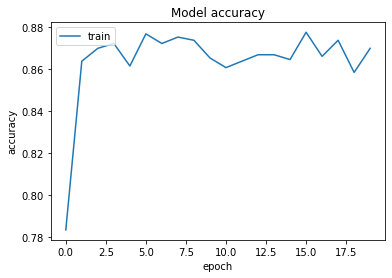

In [32]:
num = 12
img = cv2.imread(test_mask_path[num], cv2.IMREAD_COLOR)
pred_img = cv2.resize(img, (32, 32))
pred_img = np.array(pred_img, dtype=np.uint8).reshape(-1, 32, 32, 3)
y_prediction = model.predict(pred_img, verbose=1)
y_pred = format(activity_map.get('c{}'.format(np.argmax(y_prediction))))
print(y_pred)
print(y_prediction)

1/1 [==============================] - 0s 2ms/step
No_mask
[[0. 1.]]


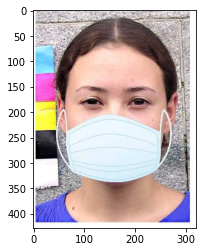

In [33]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [40]:
for i in range(100):
    num = 1
    img = cv2.imread(val_mask_path[i], cv2.IMREAD_COLOR)
    pred_img = cv2.resize(img, (32, 32))
    pred_img = np.array(pred_img, dtype=np.uint8).reshape(-1, 32, 32, 3)
    y_prediction = model.predict(pred_img, verbose=1)
    y_pred = format(activity_map.get('c{}'.format(np.argmax(y_prediction))))
    print(y_pred)
    print(y_prediction)

1/1 [==============================] - 0s 1ms/step
No_mask
[[0. 1.]]
1/1 [==============================] - 0s 992us/step
No_mask
[[0. 1.]]
1/1 [==============================] - 0s 992us/step
No_mask
[[0. 1.]]
1/1 [==============================] - 0s 1ms/step
No_mask
[[0. 1.]]
1/1 [==============================] - 0s 1ms/step
No_mask
[[0. 1.]]
1/1 [==============================] - 0s 992us/step
No_mask
[[0. 1.]]
1/1 [==============================] - 0s 992us/step
No_mask
[[0. 1.]]
1/1 [==============================] - 0s 1ms/step
No_mask
[[0. 1.]]
1/1 [==============================] - 0s 1ms/step
No_mask
[[0. 1.]]
1/1 [==============================] - 0s 2ms/step
No_mask
[[0. 1.]]
1/1 [==============================] - 0s 1ms/step
No_mask
[[0. 1.]]
1/1 [==============================] - 0s 993us/step
No_mask
[[0. 1.]]
1/1 [==============================] - 0s 992us/step
No_mask
[[0. 1.]]
1/1 [==============================] - 0s 993us/step
No_mask
[[0. 1.]]
1/1 [===============

IndexError: list index out of range